## 项目背景
> 目前运营做的流失召回，大部分是针对已经流失的用户，由于用户大部分已经流失了，再次挽回的效果并不好，就像分手的情侣一样，已经分手大半个月了，你再去挽回一样。  
更好的做法是，在用户已经有流失的迹象时，马上采取相应的运营手段，这样才能更有效地防止流失。  
我们这次的目的主要是找出未来7天内不登录的用户，这些用户不一定流失，但是不登录玩牌的话，对游戏的贡献也相当于0，所以有必要采取运营措施  

## 预测变量
用户在未来7日内是否有登录，有登录记录为0（不论次数），未登录记录为1。变量名：if_away
## 分析变量
根据反复测试，选定以下变量
* 用户分值 label_score
* 用户本周分值 label_score_week
* 用户本月分值 label_score_month
* 玩牌分值变化率 play_score_alteration
* 玩牌总时长 play_duration_life
* 最近7日玩牌总时长 play_duration_7d
* 最近30日玩牌总时长 play_duration_30d
* 玩牌总局数 total_innings
* 最近7日玩牌局数 innings_7d
* 最近30日玩牌总局数 innings_30d
* 付费次数 pay_count
* 最近7日付费次数 pay_count_7d
* 付费额度 pay_sum
* 最近7日付费额度 pay_sum_7d
* 破产次数 bankrupt_count
* 最近7日破产次数 bankrupt_count_7d
* 登录总次数 login_count
* 最近7日登陆总次数 login_count_7d
* 赢牌局数 win_innings
* 最近7日赢牌局数 win_innings_7d
* 输牌局数 lose_innings
* 最近7日输牌局数 lose_innings_7d
* 胜率 win_rate
* 最近7日胜率 win_rate_7d
* 生命周期 lifespan
* 注册至今天数 signup_to_now_days
* 总银币 total_silver_coin
* 总金条 total_gold_bar
* 携带银币数 carrying_silver_coin
* 携带金条数 carrying_gold_bar
* 保险箱银币数 safebox_silver_coin
* 保险箱金条数 safebox_gold_coin
* 比赛局数 match_innings
* 比赛时长 match_duration
* 比赛胜率 match_win_rate
* VIP剩余天数 vip_left_days
* 领取救济次数 relieve_count
* 领取救济总额 relieve_silver_coins
* 最后活跃日期距离当前的天数 last_active_to_now_days
* 最后付费日期距离当前的天数 last_pay_to_now_days
* 最近连续登陆天数 recent_login_series_days
* 最后玩牌输赢货币量 latest_play_coins

为了方便最后分析，加上以下变量，但是不纳入特征变量中：
* 平台 platformname
* 用户id mid
* 时间 dt

## 项目风险及应对
1. 模型效果不好（准确度不高）
    * 增加特征
    * 先对用户进行大体的分类，再分别制定模型
2. 模型不稳定
    * 多选取几个时间窗口样本进行测试
    * 对重要的特征值进行监测
    
## 项目的落地应用价值
* 提前锁定有高流失风险的用户群体，从而可以使运营有针对性地开展挽留
* 可以将建模过程中发现的有价值的、最有可能影响流失的重要字段提供给运营，用于制定运营方案和策略


## 抽取样本数据
#### 取数建表：
1. 从活跃表中，随机选取10000行数据，时间范围在上上周和上周之间有活跃的用户，建表1
2. 表1关联活跃表，标记出表1中的用户在最近7日内是否有登录，建表2
3. 将表2关联画像表、牌局表、付费表等，选取上面的指标，建表3
#### 取字段时，把null值替换成0

## 模型分值判定标准
通过查看数据发现，流失用户占比大概为25%，可见这是一个不平衡的数据，有一种办法是人为采取不均衡采样，即未流失用户欠采样，使得两者各占50%。我们暂时不对样本进行处理  
由于我们的目的是：尽可能多地准确预测出流失用户，但同时不能够把未流失的用户判定为流失（防止对用户进行打扰），所以我们采用F1-score作为模型的评分标准。

## 加载数据

In [101]:
import pandas as pd
import numpy as np
from pandas import Series,DataFrame
import matplotlib as mpl
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVR
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.preprocessing import Normalizer
pd.options.display.max_columns = None

In [11]:
data = pd.read_csv('./csvs/data.csv')
data.shape

(10000, 52)

## 数据清洗
包括：  
* 缺失和异常字段处理
* 数据转换
    * 产生衍生变量
    * 改善变量分布特征的转换
    * 区间型变量的分箱转换
    * 针对区间型变量进行的标准化操作
* 变量之间的相关性分析，找出潜在共线性问题的变量
* 对不符合逻辑的数据进行处理

### 缺失字段处理

In [47]:
all_data = dict(data.shape[0]-data.count())
for i in all_data:
    if all_data[i] != 0:
        print("%s:"%i,all_data[i])

label_score_week: 497
play_score_alteration: 497
play_passion_7day: 497
pay_passion_7day: 497


In [57]:
data[data['label_score_week'].isnull().values == True].head(10)

,fuid,fplatformname,dt,if_away,label_score_week,label_score_month,play_score_alteration,label_score,play_passion_7day,pay_passion_7day,play_passion_30day,pay_passion_30day,lifespan,signup_to_now_days,total_silver_coin,total_gold_bar,carrying_silver_coin,carrying_gold_bar,safebox_silver_coin,safebox_gold_bar,if_vip,play_duration_life,play_duration_30day,play_duration_7day,play_innings_life,play_innings_30day,play_innings_7day,win_innings_life,win_innings_7day,lose_innings_life,lose_innings_7day,win_rate_life,win_rate_7day,pay_count_life,pay_count_30day,pay_count_7day,pay_sum_life,pay_sum_30day,pay_sum_7day,login_count_life,login_count_7day,bankrupt_count_life,bankrupt_count_7day,relieve_count_life,relieve_silver_coins_life,match_innings_life,match_duration_life,match_win_rate_life,recent_login_series_days,latest_play_coins,last_active_to_now_days,last_pay_to_now_days
10,10269788,四川,2018-07-02,0,NaN,9,NaN,9,NaN,NaN,2,0,463,465,7780,5,7780,5,0,0,0,93761,1900,0,907,16,0,276,0,507,0,0.3043,0.0,0,0,0,0.00,0.0,0.0,149,2,67,0,45,360000,793,81869,0.0038,0,-1520,2,0
18,7164976,江西,2018-07-02,1,NaN,9,NaN,9,NaN,NaN,9,0,518,519,0,0,0,0,0,0,0,302041,6676,0,4351,78,0,1871,0,2414,0,0.4300,0.0,6,0,0,76.00,0.0,0.0,942,3,79,0,51,408000,3395,217145,0.0000,0,-3940,1,418
66,1002947195,香港,2018-07-02,1,NaN,8,NaN,8,NaN,NaN,39,0,46,51,519701,59,519701,59,0,0,0,126140,71560,0,839,479,0,223,0,289,0,0.2658,0.0,0,0,0,0.00,0.0,0.0,211,1,35,0,19,95000,42,4386,0.2857,0,-64000,5,0
79,7063045,云南,2018-07-02,1,NaN,9,NaN,9,NaN,NaN,3,0,521,522,20012,0,20012,0,0,0,0,783036,1195,0,9818,15,0,4322,0,4729,0,0.4402,0.0,4,0,0,12.00,0.0,0.0,1801,4,359,0,324,2592000,6022,635188,0.0028,0,-8640,1,261
89,1002467879,香港,2018-07-02,1,NaN,8,NaN,8,NaN,NaN,20,0,189,191,15000,0,15000,0,0,0,0,103313,49555,0,764,347,0,220,0,281,0,0.2880,0.0,1,0,0,0.99,0.0,0.0,92,1,12,0,10,63000,0,0,1.0000,0,-120820,2,185
114,1002986846,香港,2018-07-02,0,NaN,8,NaN,8,NaN,NaN,10,0,29,29,37212,10,37212,10,0,0,0,6806,6806,0,82,82,0,41,0,38,0,0.5000,0.0,0,0,0,0.00,0.0,0.0,42,4,0,0,0,0,79,6217,0.5063,3,-4800,0,0
165,20278710,云南,2018-07-02,1,NaN,9,NaN,9,NaN,NaN,9,0,143,145,25488,0,8550,0,16938,0,0,18407,6220,0,274,30,0,54,0,218,0,0.1971,0.0,0,0,0,0.00,0.0,0.0,40,2,2,0,2,16000,0,0,1.0000,0,-2160,2,0
236,18202628,云南,2018-07-02,1,NaN,9,NaN,9,NaN,NaN,4,0,314,314,70525,0,10621,0,59904,0,0,88022,1598,0,817,14,0,208,0,498,0,0.2546,0.0,0,0,0,0.00,0.0,0.0,97,1,8,0,8,64000,553,62100,0.0000,1,-5200,0,0
237,13113628,山东,2018-07-02,0,NaN,8,NaN,8,NaN,NaN,12,0,395,397,63707,0,2000,0,61707,0,0,537457,9396,0,7016,101,0,2606,0,4411,0,0.3714,0.0,0,0,0,0.00,0.0,0.0,745,2,111,0,103,824000,1837,186188,0.0000,0,-3621,2,0
240,1003010743,香港,2018-07-02,1,NaN,9,NaN,9,NaN,NaN,2,0,7,13,9500,0,9500,0,0,0,0,1977,1977,0,15,15,0,2,0,8,0,0.1333,0.0,0,0,0,0.00,0.0,0.0,4,1,1,0,1,5000,0,0,1.0000,0,-10800,6,0


#### 通过研究发现，这几个变量之所以为空，是因为这些用户虽然有登录，但是最近7日并没有玩牌，所以将null值处理为0即可

In [58]:
data.fillna('0',inplace=True)

### 异常值处理

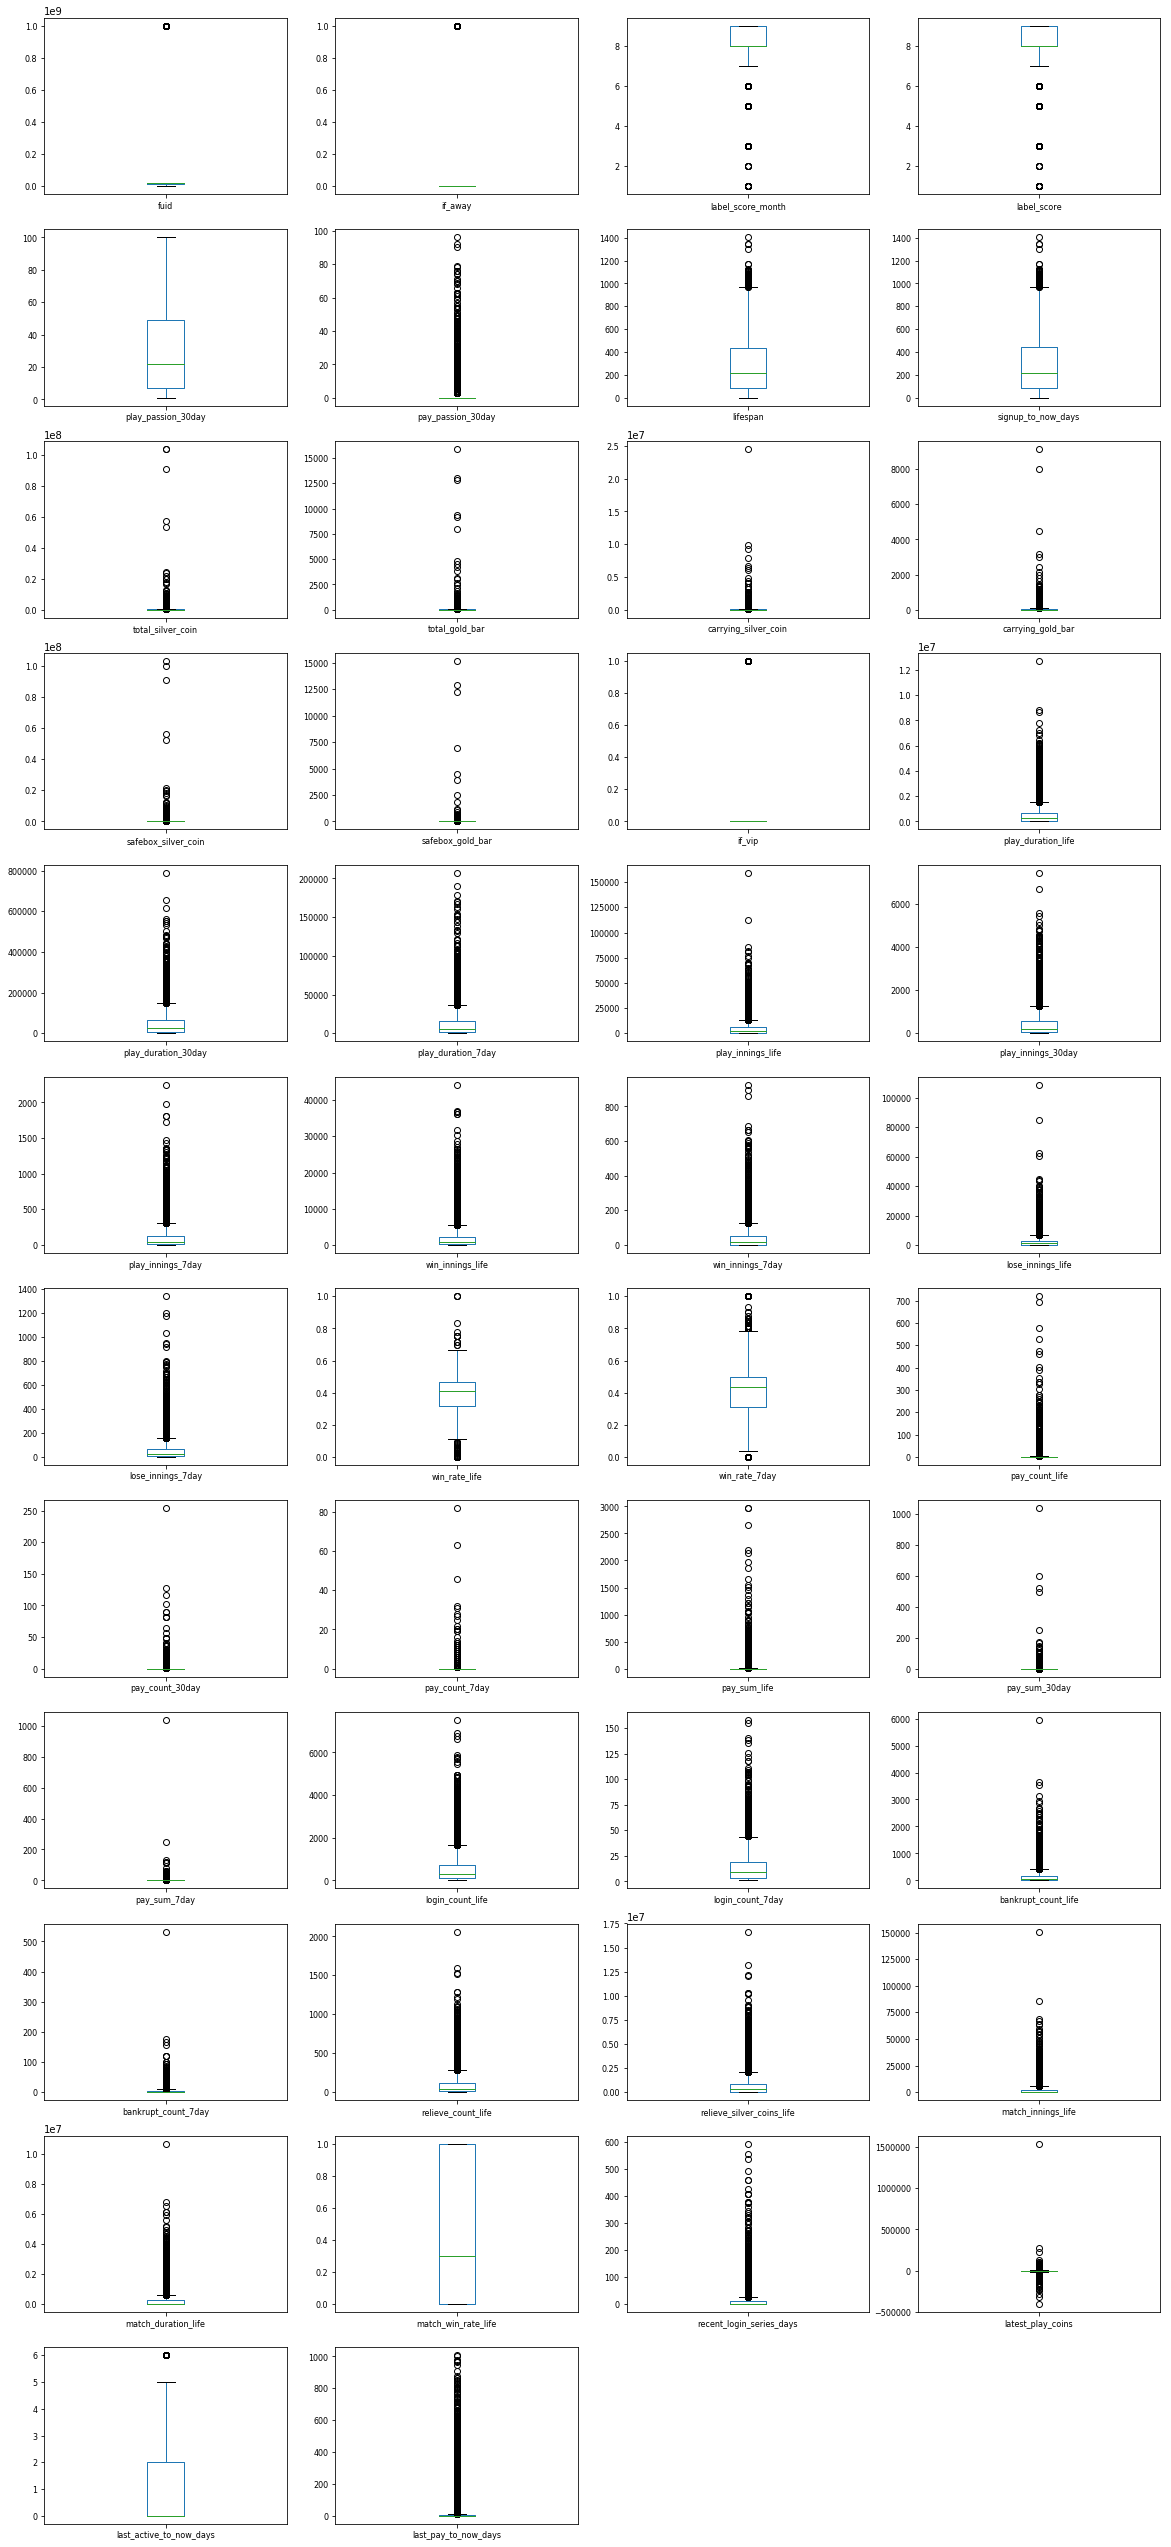

In [79]:
data.plot(kind='box',subplots=True,layout=(13,4),figsize=(20,50),sharex=False,sharey=False,fontsize=8);

#### 可见很多变量都有一些离群点，我们根据上图，对变量进行排序，找到这些数据

In [85]:
data.sort_values(by='pay_count_30day',ascending=False).head(5)

,fuid,fplatformname,dt,if_away,label_score_week,label_score_month,play_score_alteration,label_score,play_passion_7day,pay_passion_7day,play_passion_30day,pay_passion_30day,lifespan,signup_to_now_days,total_silver_coin,total_gold_bar,carrying_silver_coin,carrying_gold_bar,safebox_silver_coin,safebox_gold_bar,if_vip,play_duration_life,play_duration_30day,play_duration_7day,play_innings_life,play_innings_30day,play_innings_7day,win_innings_life,win_innings_7day,lose_innings_life,lose_innings_7day,win_rate_life,win_rate_7day,pay_count_life,pay_count_30day,pay_count_7day,pay_sum_life,pay_sum_30day,pay_sum_7day,login_count_life,login_count_7day,bankrupt_count_life,bankrupt_count_7day,relieve_count_life,relieve_silver_coins_life,match_innings_life,match_duration_life,match_win_rate_life,recent_login_series_days,latest_play_coins,last_active_to_now_days,last_pay_to_now_days
6520,1002732910,香港,2018-07-02,0,1,1,0,1,100,85,100,92,118,118,15232,220,7913,220,7319,0,0,1238096,381751,103385,15248,4728,1262,6564,564,8684,698,0.4305,0.4469,719,254,63,716.81,251.46,62.37,935,68,1197,99,332,1660000,0,0,1.0000,68,2957,0,0
5548,6982216,辽宁,2018-07-02,0,1,1,-0.0344828,1,90,60,87,66,524,524,64000,0,880,0,63120,0,1,2483934,172048,53516,18501,1343,409,5960,140,12328,264,0.3221,0.3465,692,128,46,750.50,64.00,23.00,5533,111,4,0,4,32000,9399,1267150,0.0000,295,-25000,0,0
4816,20665078,云南,2018-07-02,0,1,1,-0.0531915,1,99,64,94,76,97,97,940,10,940,10,0,0,1,477526,396196,120860,5337,4393,1337,2350,563,2955,756,0.4403,0.4268,127,117,31,137.50,131.00,27.50,192,36,254,48,130,1040000,43,3242,0.3488,29,-3940,0,0
6228,12312730,云南,2018-07-02,0,5,1,0.337349,1,55,46,83,63,407,407,1747,48,1747,48,0,0,0,2154298,214746,36232,33909,2968,546,15162,245,18158,280,0.4471,0.4667,229,102,20,204.50,52.50,10.00,3046,43,2867,156,790,6320000,19659,1239689,0.2174,1,-18000,0,3
5818,6643353,云南,2018-07-02,0,1,1,-0.0107527,1,94,68,93,79,532,532,18875,0,18875,0,0,0,1,2320448,247217,76885,28432,2156,668,10697,190,17494,468,0.3762,0.2888,527,90,22,1032.50,169.50,39.50,3337,64,1206,6,783,6264000,17778,1101688,0.0000,67,-1800,0,0


In [84]:
data.sort_values(by='carrying_silver_coin',ascending=False).head(5)

,fuid,fplatformname,dt,if_away,label_score_week,label_score_month,play_score_alteration,label_score,play_passion_7day,pay_passion_7day,play_passion_30day,pay_passion_30day,lifespan,signup_to_now_days,total_silver_coin,total_gold_bar,carrying_silver_coin,carrying_gold_bar,safebox_silver_coin,safebox_gold_bar,if_vip,play_duration_life,play_duration_30day,play_duration_7day,play_innings_life,play_innings_30day,play_innings_7day,win_innings_life,win_innings_7day,lose_innings_life,lose_innings_7day,win_rate_life,win_rate_7day,pay_count_life,pay_count_30day,pay_count_7day,pay_sum_life,pay_sum_30day,pay_sum_7day,login_count_life,login_count_7day,bankrupt_count_life,bankrupt_count_7day,relieve_count_life,relieve_silver_coins_life,match_innings_life,match_duration_life,match_win_rate_life,recent_login_series_days,latest_play_coins,last_active_to_now_days,last_pay_to_now_days
460,19580719,江西,2018-07-02,0,6,6,-0.0142857,6,71,0,70,0,224,224,24496377,0,24496377,0,0,0,1,1210465,98748,22118,21996,1803,396,9791,173,11569,211,0.4451,0.4505,0,0,0,0.0,0.0,0.0,1012,30,0,0,0,0,0,0,1.0000,46,-3000,0,0
465,19980815,山东,2018-07-02,1,9,9,0,9,4,0,4,0,181,181,9943944,29,9943944,29,0,0,0,751150,3086,564,20536,10,2,5166,2,15364,0,0.2516,1.0000,25,0,0,114.0,0.0,0.0,809,1,61,0,37,296000,44,3230,0.5227,1,11338,0,152
9053,3290368,四川,2018-07-02,0,6,6,-0.414286,6,99,0,70,0,699,699,9201263,0,9201263,0,0,0,0,852388,318082,98100,7738,2454,769,4207,511,3530,258,0.5437,0.6645,0,0,0,0.0,0.0,0.0,416,33,231,0,173,1384000,5050,508505,0.0000,23,18000,0,0
7619,4918056,辽宁,2018-07-02,0,8,8,-0.514286,8,53,0,35,0,581,581,19977721,154,7916539,154,12061182,0,0,1891402,33128,5054,22181,444,71,7985,37,14154,32,0.3600,0.5362,2,0,0,33.0,0.0,0.0,1542,9,248,0,162,1296000,19065,1640937,0.1875,8,-500,0,571
1718,6989430,辽宁,2018-07-02,0,6,6,-0.0972222,6,79,0,72,0,524,524,6698170,0,6698170,0,0,0,0,1235423,153019,32425,4114,530,112,2489,62,1561,48,0.6050,0.5636,0,0,0,0.0,0.0,0.0,465,21,3,0,3,24000,2114,646104,0.0000,17,-18000,0,0


In [86]:
data.sort_values(by='latest_play_coins',ascending=False).head(5)

,fuid,fplatformname,dt,if_away,label_score_week,label_score_month,play_score_alteration,label_score,play_passion_7day,pay_passion_7day,play_passion_30day,pay_passion_30day,lifespan,signup_to_now_days,total_silver_coin,total_gold_bar,carrying_silver_coin,carrying_gold_bar,safebox_silver_coin,safebox_gold_bar,if_vip,play_duration_life,play_duration_30day,play_duration_7day,play_innings_life,play_innings_30day,play_innings_7day,win_innings_life,win_innings_7day,lose_innings_life,lose_innings_7day,win_rate_life,win_rate_7day,pay_count_life,pay_count_30day,pay_count_7day,pay_sum_life,pay_sum_30day,pay_sum_7day,login_count_life,login_count_7day,bankrupt_count_life,bankrupt_count_7day,relieve_count_life,relieve_silver_coins_life,match_innings_life,match_duration_life,match_win_rate_life,recent_login_series_days,latest_play_coins,last_active_to_now_days,last_pay_to_now_days
5377,11128865,云南,2018-07-02,0,6,6,-0.027027,6,76,0,74,0,440,440,103442241,23,3410979,23,100031262,0,1,2213862,88172,28607,32590,1043,326,12564,148,19798,171,0.3855,0.4639,0,0,0,0.0,0.0,0.0,2612,48,69,0,55,440000,29741,2033352,0.0051,47,1536000,0,0
5596,19428944,辽宁,2018-07-02,0,1,1,-0.137931,1,99,71,87,74,237,237,1343195,10,1343195,10,0,0,1,1830332,250579,107559,15748,2045,857,3821,202,11826,649,0.2426,0.2374,72,10,4,1869.0,496.0,248.0,2154,95,110,3,79,632000,1015,117716,0.0020,16,274907,0,2
3456,20794643,辽宁,2018-07-02,0,6,8,-0.173077,8,61,0,52,0,76,76,441908,0,441908,0,0,0,0,174654,62327,13783,1298,440,94,346,29,946,64,0.2666,0.3118,0,0,0,0.0,0.0,0.0,300,28,117,15,108,864000,0,0,1.0000,14,230000,0,0
3925,5523998,云南,2018-07-02,1,9,9,-1,9,4,0,2,0,557,562,1607730,0,335112,0,1272618,0,0,168275,347,347,4047,18,18,922,8,3069,8,0.2278,0.5000,5,0,0,18.0,0.0,0.0,215,1,51,0,15,120000,4011,167581,0.0000,0,129600,5,524
2483,1002866939,香港,2018-07-02,0,8,8,0.0465116,8,41,0,43,0,83,83,397252,200,397252,200,0,0,0,136696,43332,12311,1618,515,137,819,65,795,68,0.5062,0.4887,0,0,0,0.0,0.0,0.0,189,13,49,0,46,230000,0,0,1.0000,81,109482,0,0


#### 可见这些离群点并不是数据错误造成的异常值，因此做保留处理

### 数据转换

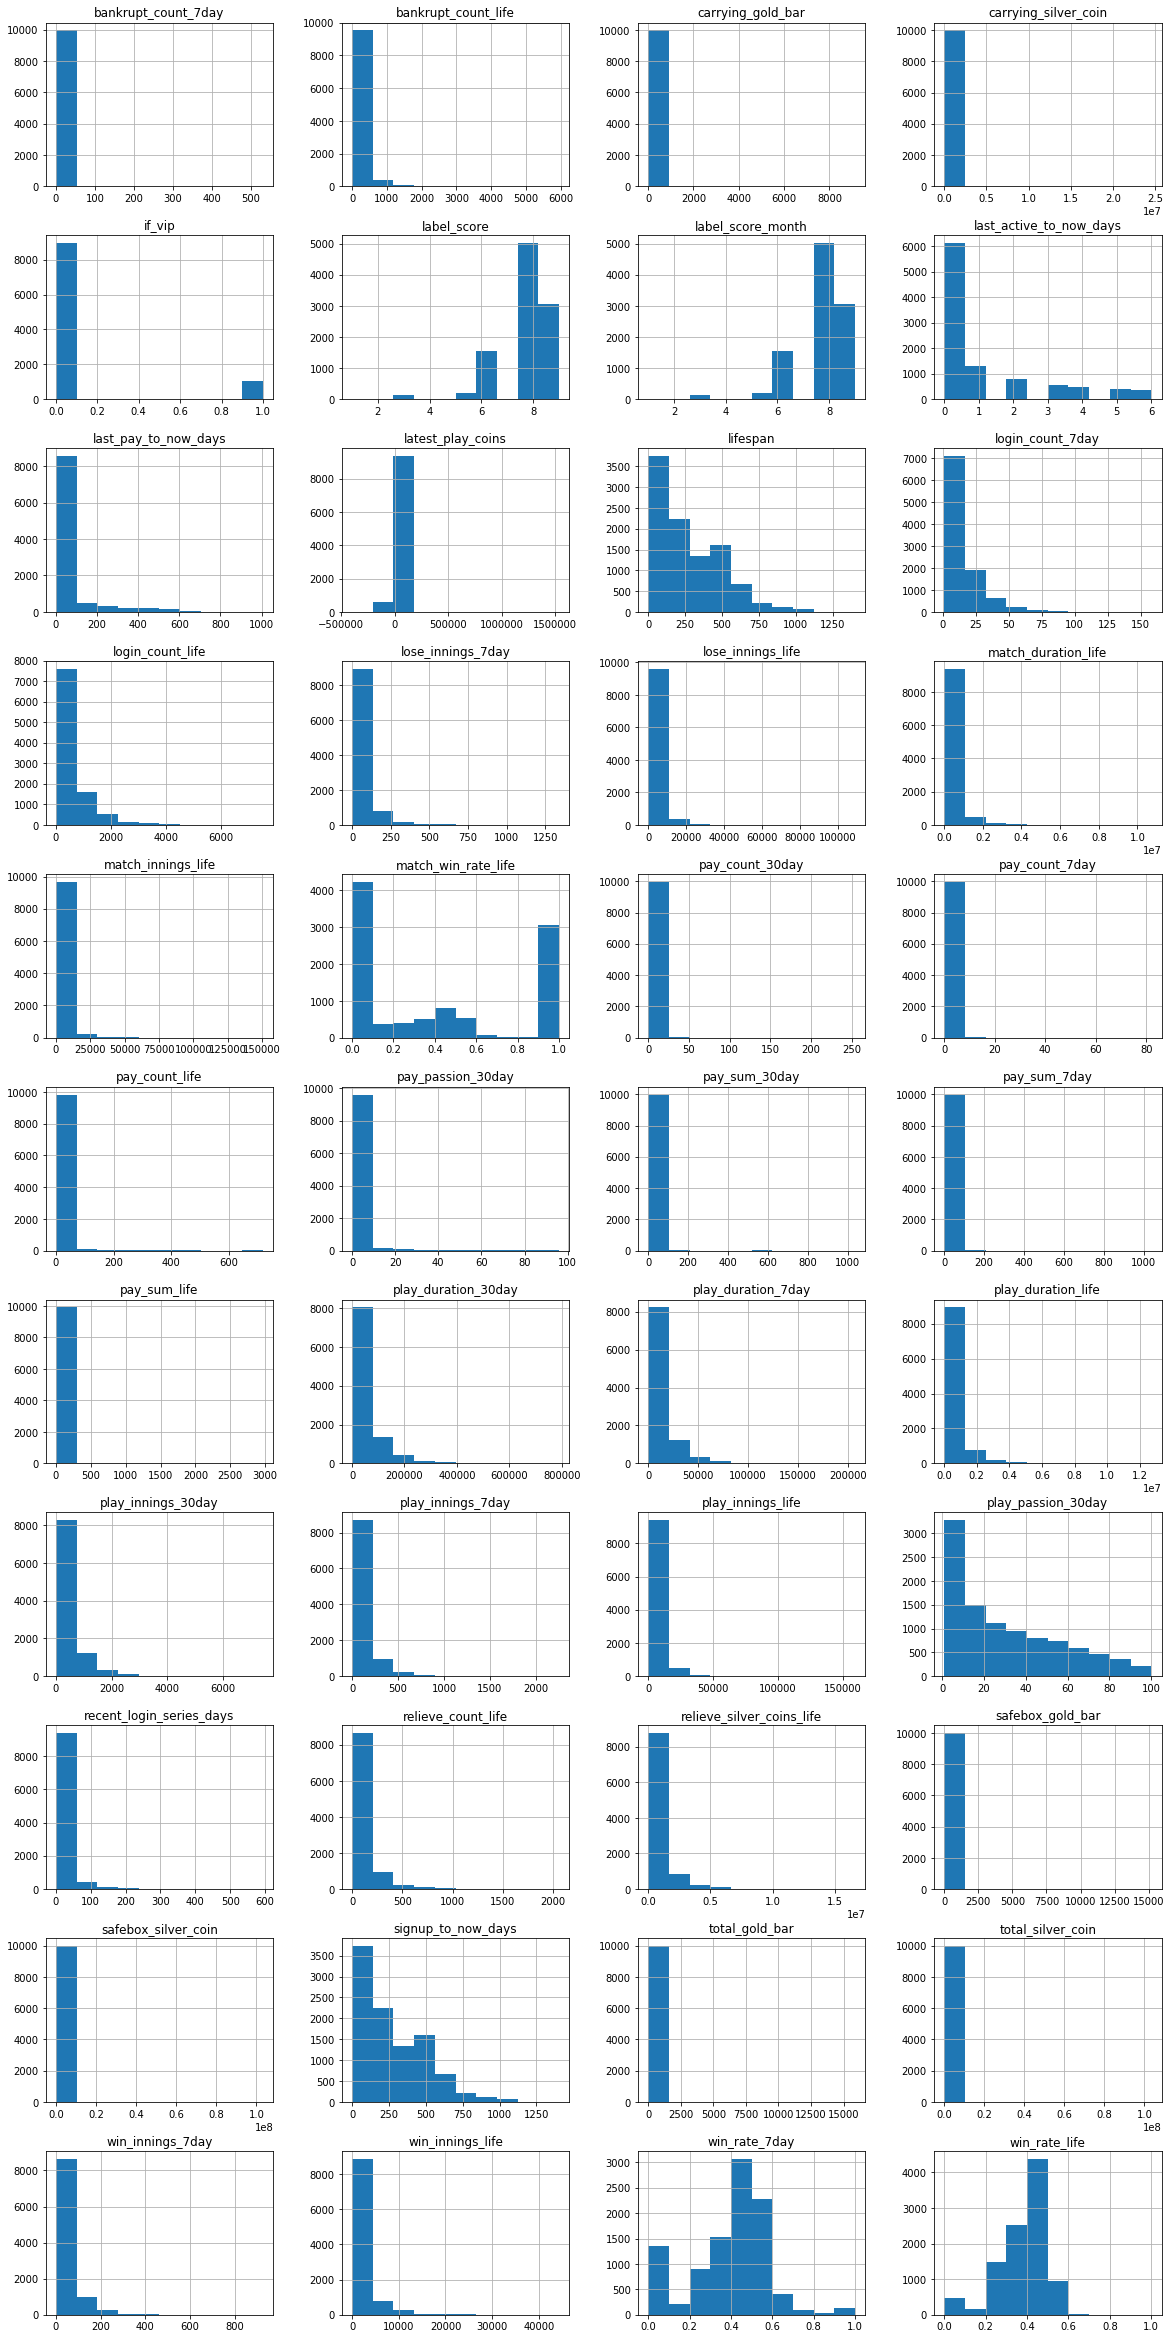

In [113]:
data.iloc[:,4:52].hist(sharex=False,sharey=False,figsize=(20,50),layout=(13,4));

#### 可见除了个别变量之外，普遍分布为右偏分布（价值分因为我选取的是越小分值越大，所以呈左偏）
#### 标准正态化

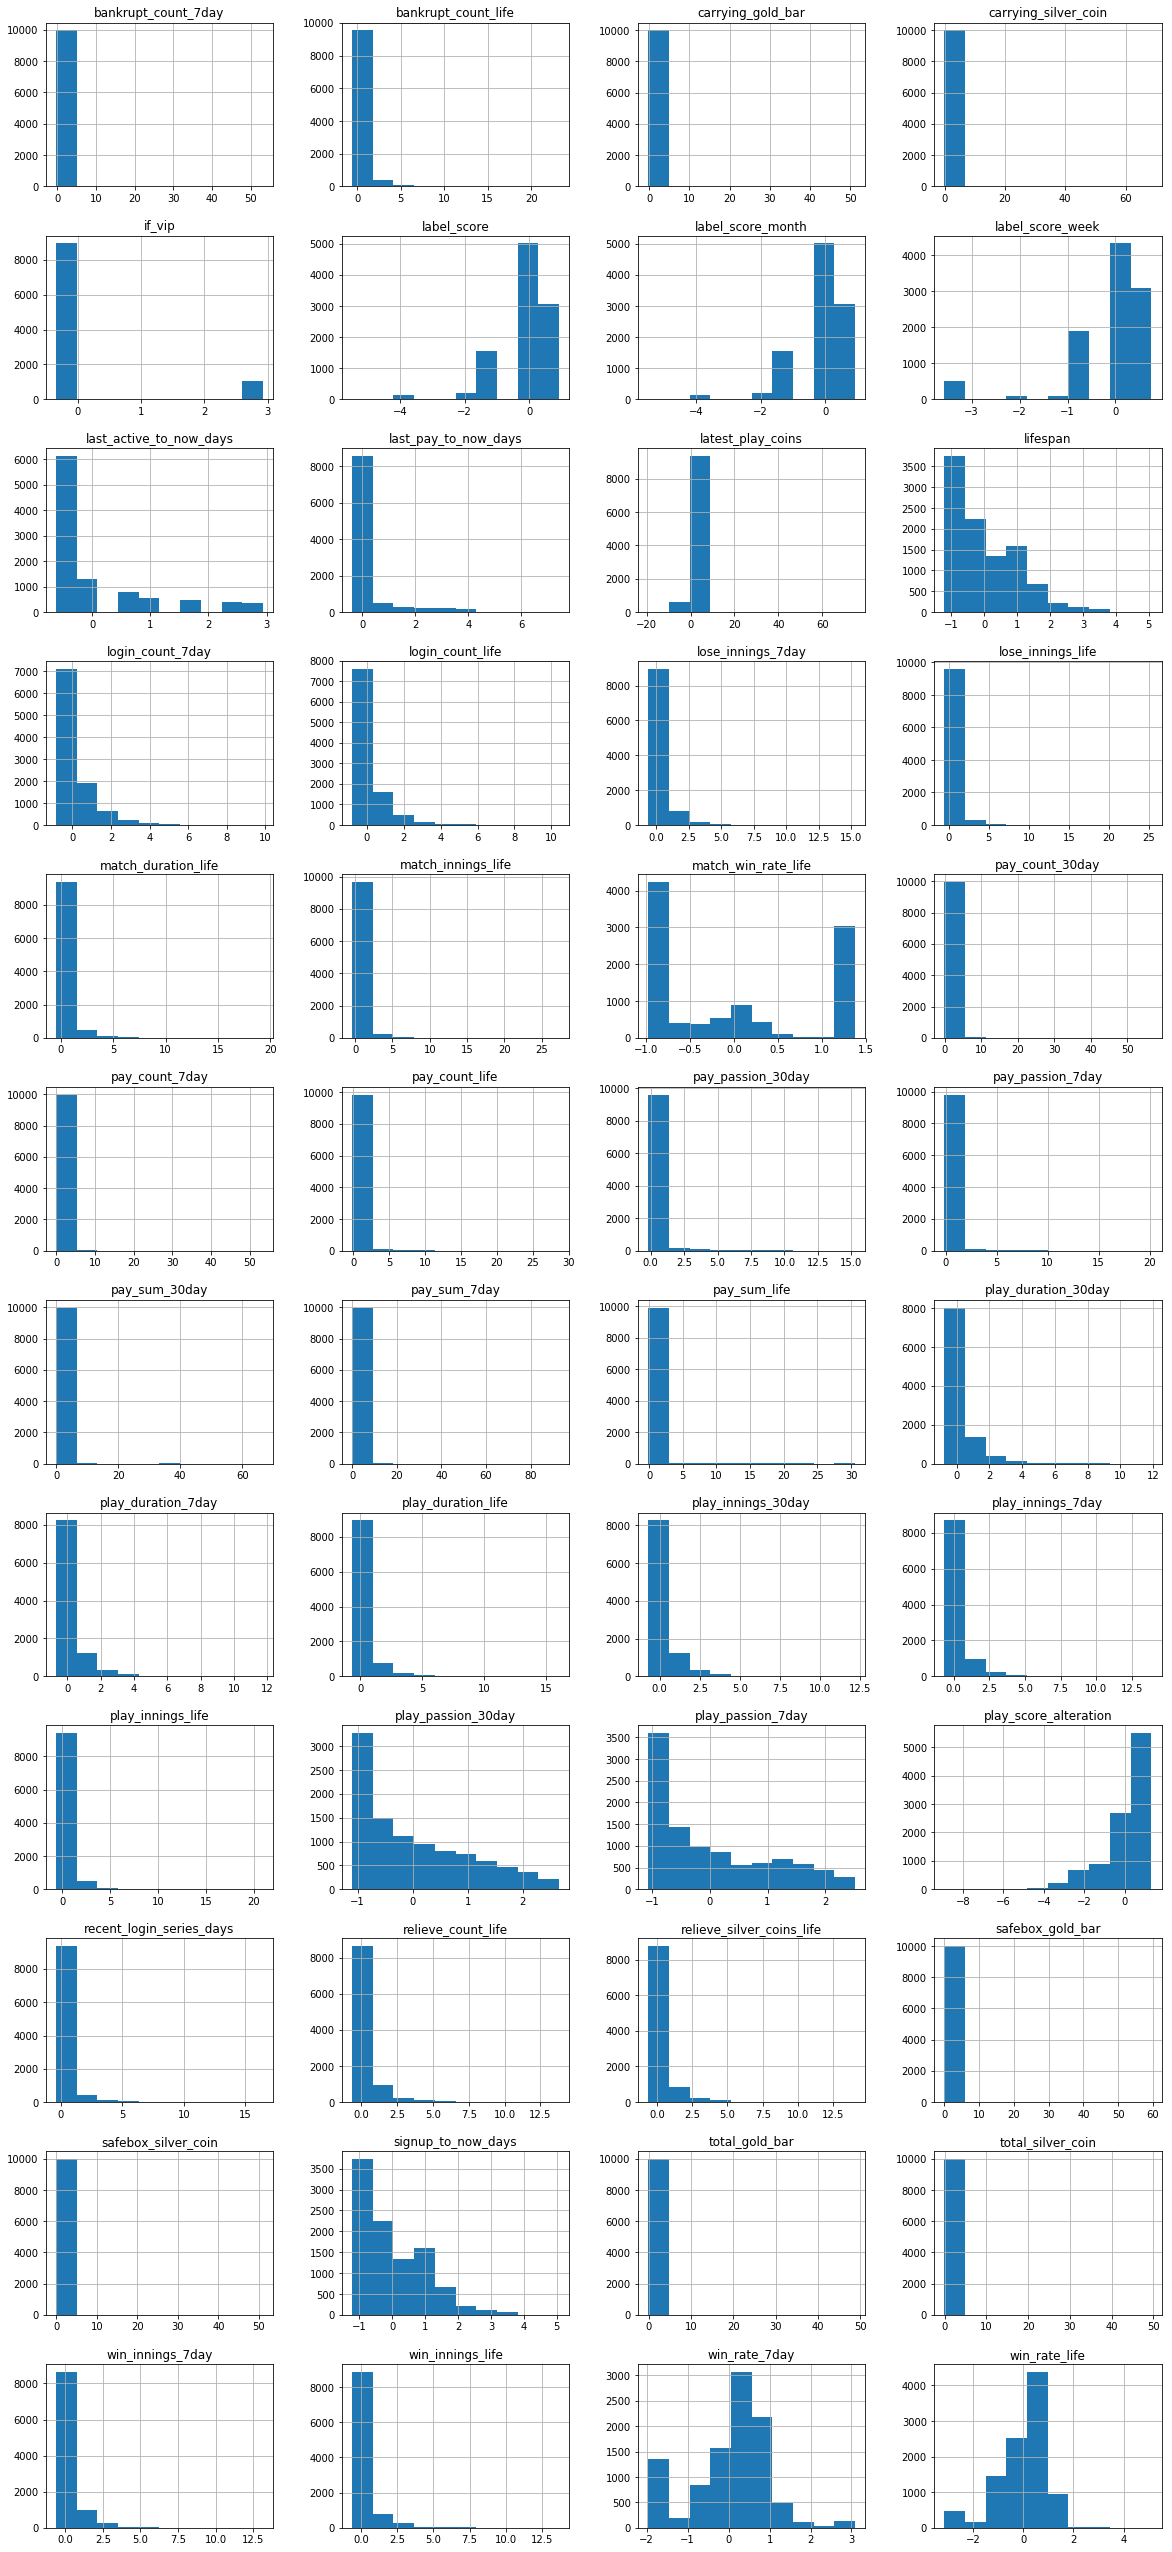

In [104]:
array= data.values
X = array[:,4:53].astype(np.float32)
scaler = Normalizer()
scaler.fit(X)
data_scaler = scaler.transform(X)
names = data.columns
scaler_data = pd.DataFrame(columns = names[4:52],data = data_scaler)
#scaler_data.head(10)
scaler_data.hist(sharex=False,sharey=False,figsize=(20,50),layout=(13,4));

#### 取对数

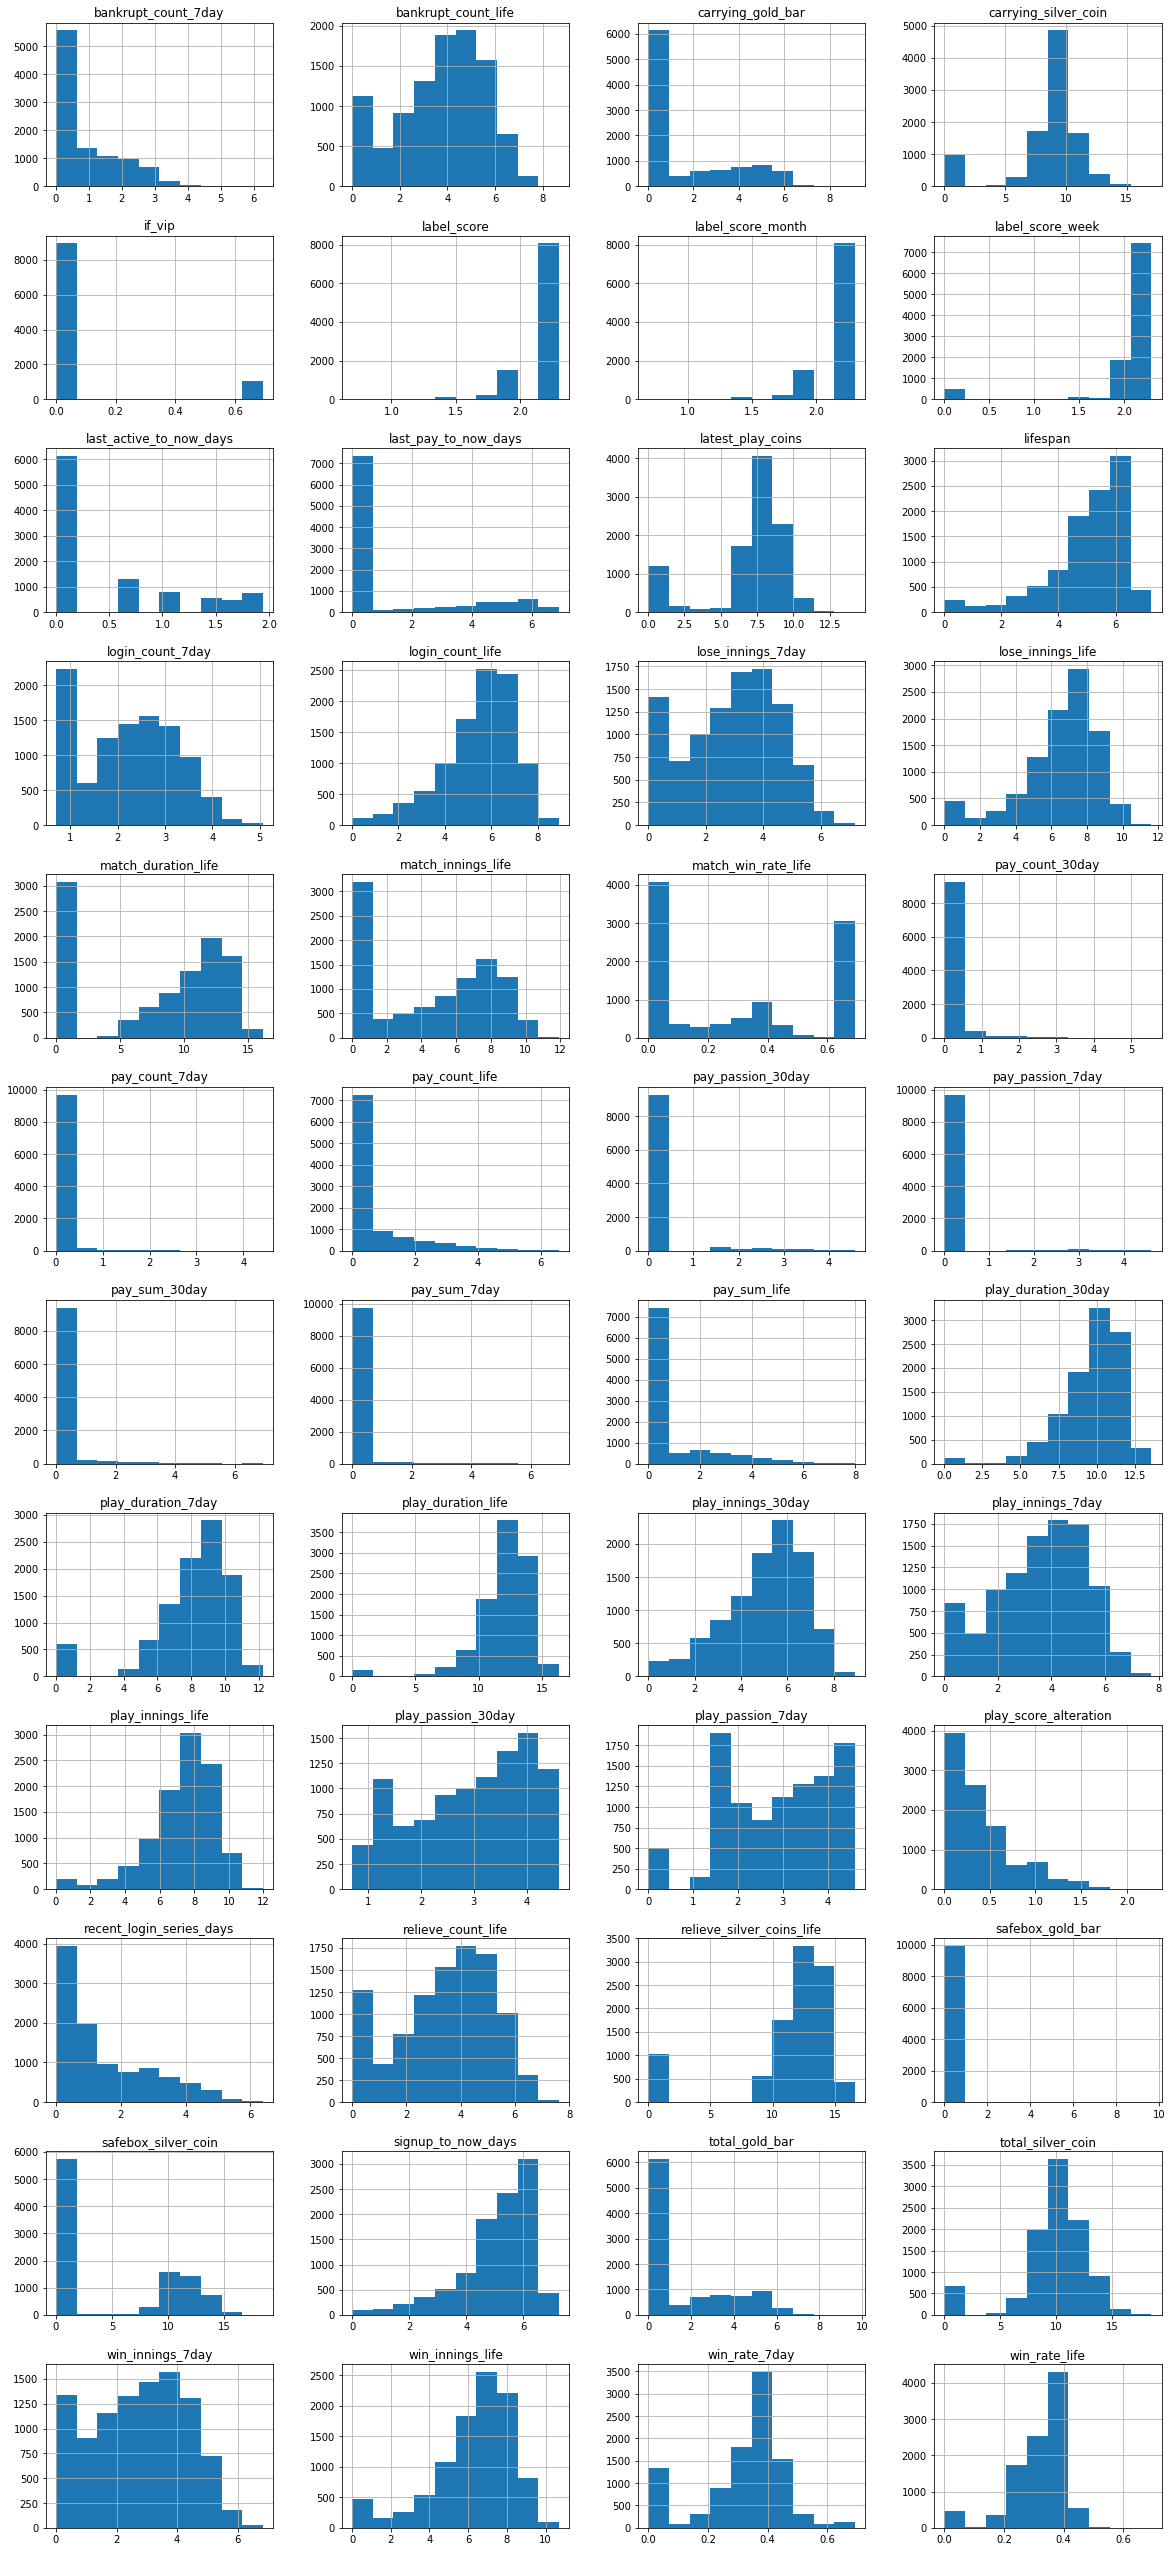

In [106]:
from sklearn.preprocessing import FunctionTransformer
X = np.abs(X)
transformer = FunctionTransformer(np.log1p)
transformer.fit(X)
data_scaler = transformer.transform(X)
names = data.columns
scaler_data = pd.DataFrame(columns = names[4:52],data = data_scaler)
#scaler_data.head(10)
scaler_data.hist(sharex=False,sharey=False,figsize=(20,50),layout=(13,4));

#### 对数据开平方

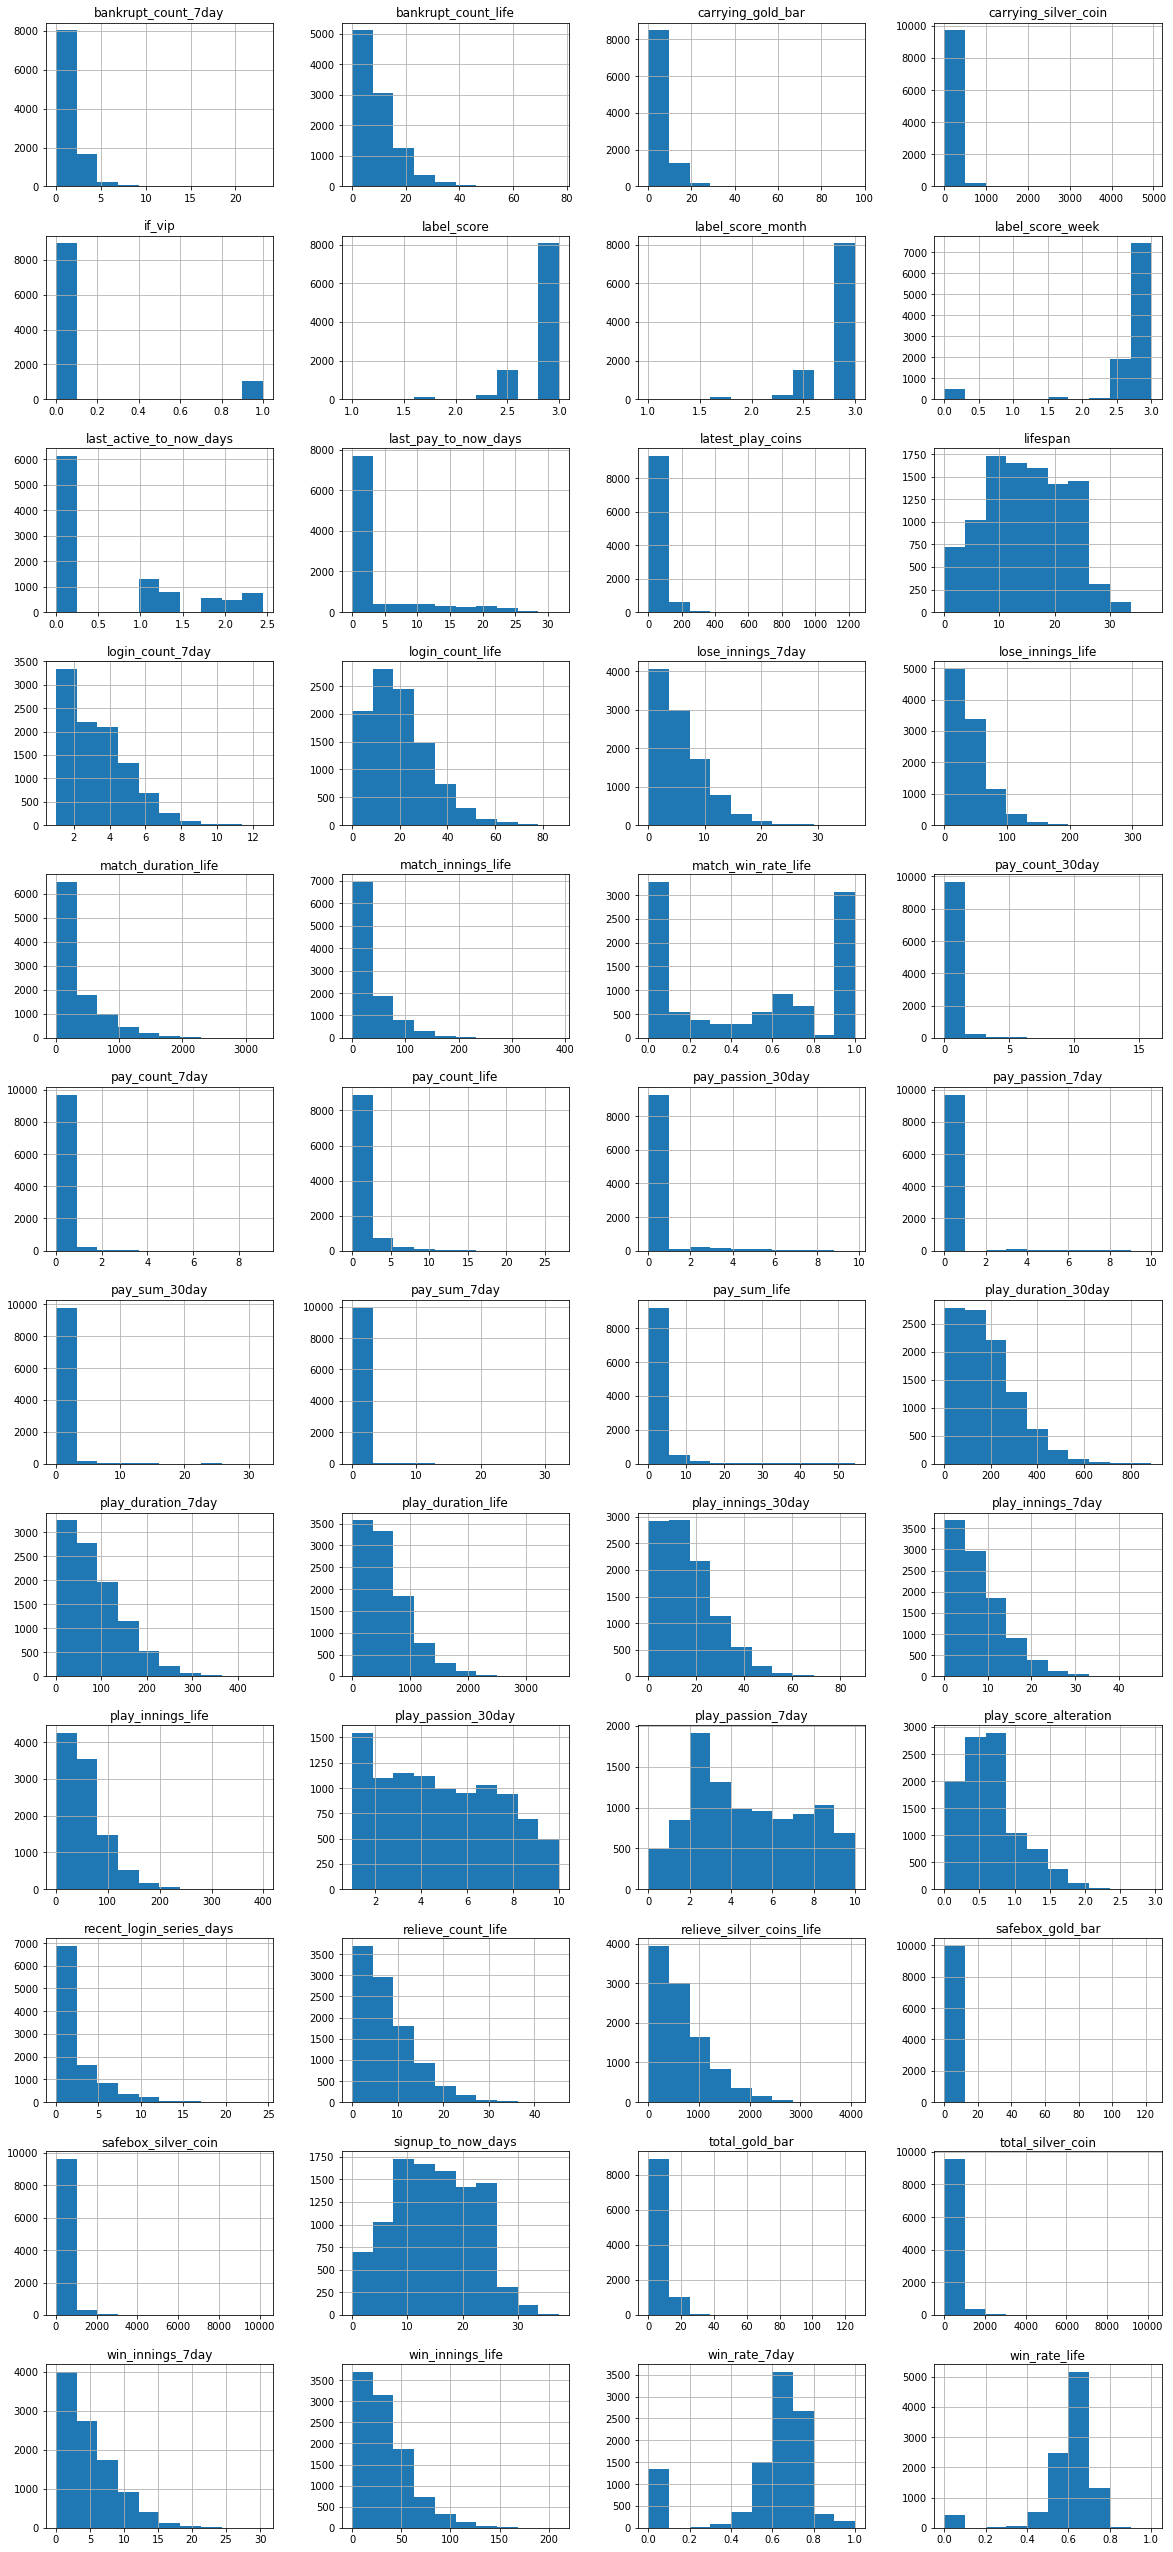

In [108]:
transformer = FunctionTransformer(np.sqrt)
transformer.fit(X)
data_scaler = transformer.transform(X)
names = data.columns
scaler_data = pd.DataFrame(columns = names[4:52],data = data_scaler)
#scaler_data.head(10)
scaler_data.hist(sharex=False,sharey=False,figsize=(20,50),layout=(13,4));

#### 看来对变量取对数效果最好

### 变量之间的相关性分析
当自变量之间存在较强的线性相关关系（也叫做多重共线性），模型参数会变得不稳定，预测能力会降低  
常用的识别共线性的方法：  
* 皮尔逊相关系数
* 通过模型结论来找
* 主成分分析法
* 对变量进行聚类，同一类中的变量之间具有较强的相似性

处理办法：  
* 是否处理共线性问题，取决于样本量，如果样本大的话，轻微的共线性可以不处理；如果样本小的话，共线性会对结果造成比较大的影响
* 对于高度共线性的变量，可以选择保留最有价值和意义的
* 生成衍生变量
* 进行形式转换

## 模型分值

In [9]:

def algorithm(X,y,score):
    num_folds = 10
    scoring = score
    seed = 7
    kfold = KFold(n_splits=num_folds,random_state=seed)
    results = []

    ## 普通算法
    models = {}
    # 逻辑回归
    models['LR'] = LogisticRegression()
    # 线性判别分析
    models['LDA'] = LinearDiscriminantAnalysis()
    # K近邻
    models['KNN'] = KNeighborsClassifier()
    # 分类与回归树
    models['CART'] = DecisionTreeClassifier()
    # 贝叶斯分类器
    models['NB'] = GaussianNB()
    # 支持向量机
    models['SVM'] = SVC()
    
    for key in models:
        cv_results = cross_val_score(models[key],X,y,cv=kfold,scoring=scoring)
        results.append(cv_results)
        print('%s: %f (%f)'% (key,cv_results.mean(),cv_results.std()))
        
    ## 集成算法
    ensembles = {}
    ensembles['ScaledAB'] = Pipeline([('Scaler',StandardScaler()),('AB',AdaBoostClassifier())])
    ensembles['ScaledGBM'] = Pipeline([('Scaler',StandardScaler()),('GBM',GradientBoostingClassifier())])
    ensembles['ScaledRF'] = Pipeline([('Scaler',StandardScaler()),('RFR',RandomForestClassifier())])
    ensembles['ScaledET'] = Pipeline([('Scaler',StandardScaler()),('ETR',ExtraTreesClassifier())])
  
    for key in ensembles:
        cv_result = cross_val_score(ensembles[key],X,y,cv=kfold,scoring=scoring)
        results.append(cv_result)
        print('%s: %f (%f)'% (key,cv_result.mean(),cv_result.std()))
        
    # 通过箱线图显示数据的分布情况
    fig = plt.figure(figsize=(18, 8), dpi=200)
    ax = fig.add_subplot(111)
    plt.boxplot(results);
    ax.set_xticklabels(list(models.keys())+list(ensembles.keys()));

In [6]:
from sklearn.preprocessing import MinMaxScaler
array= data.values
X = array[:,4:53].astype(np.float32)
y = array[:,3].astype(np.float32)
# 调整数据尺度
transformer = MinMaxScaler(feature_range=(0,1))
scaledX = transformer.fit_transform(X)

validation_size = 0.2
seed = 7
X_t,X_v,y_t,y_v = train_test_split(scaledX,y,test_size=validation_size,random_state=seed)

LR: 0.500212 (0.039247)
CART: 0.479788 (0.039785)
NB: 0.440370 (0.029840)
SVM: 0.400598 (0.035092)


/usr/lib64/python3.4/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/usr/lib64/python3.4/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/usr/lib64/python3.4/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/usr/lib64/python3.4/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/usr/lib64/python3.4/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/usr/lib64/python3.4/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/usr/lib64/python3.4/site-packages/sklearn/discriminant_analysis.py:38

LDA: 0.526489 (0.033386)
KNN: 0.483258 (0.032334)
ScaledGBM: 0.544209 (0.033063)
ScaledAB: 0.532373 (0.037550)
ScaledRF: 0.467200 (0.025358)
ScaledET: 0.472645 (0.035997)


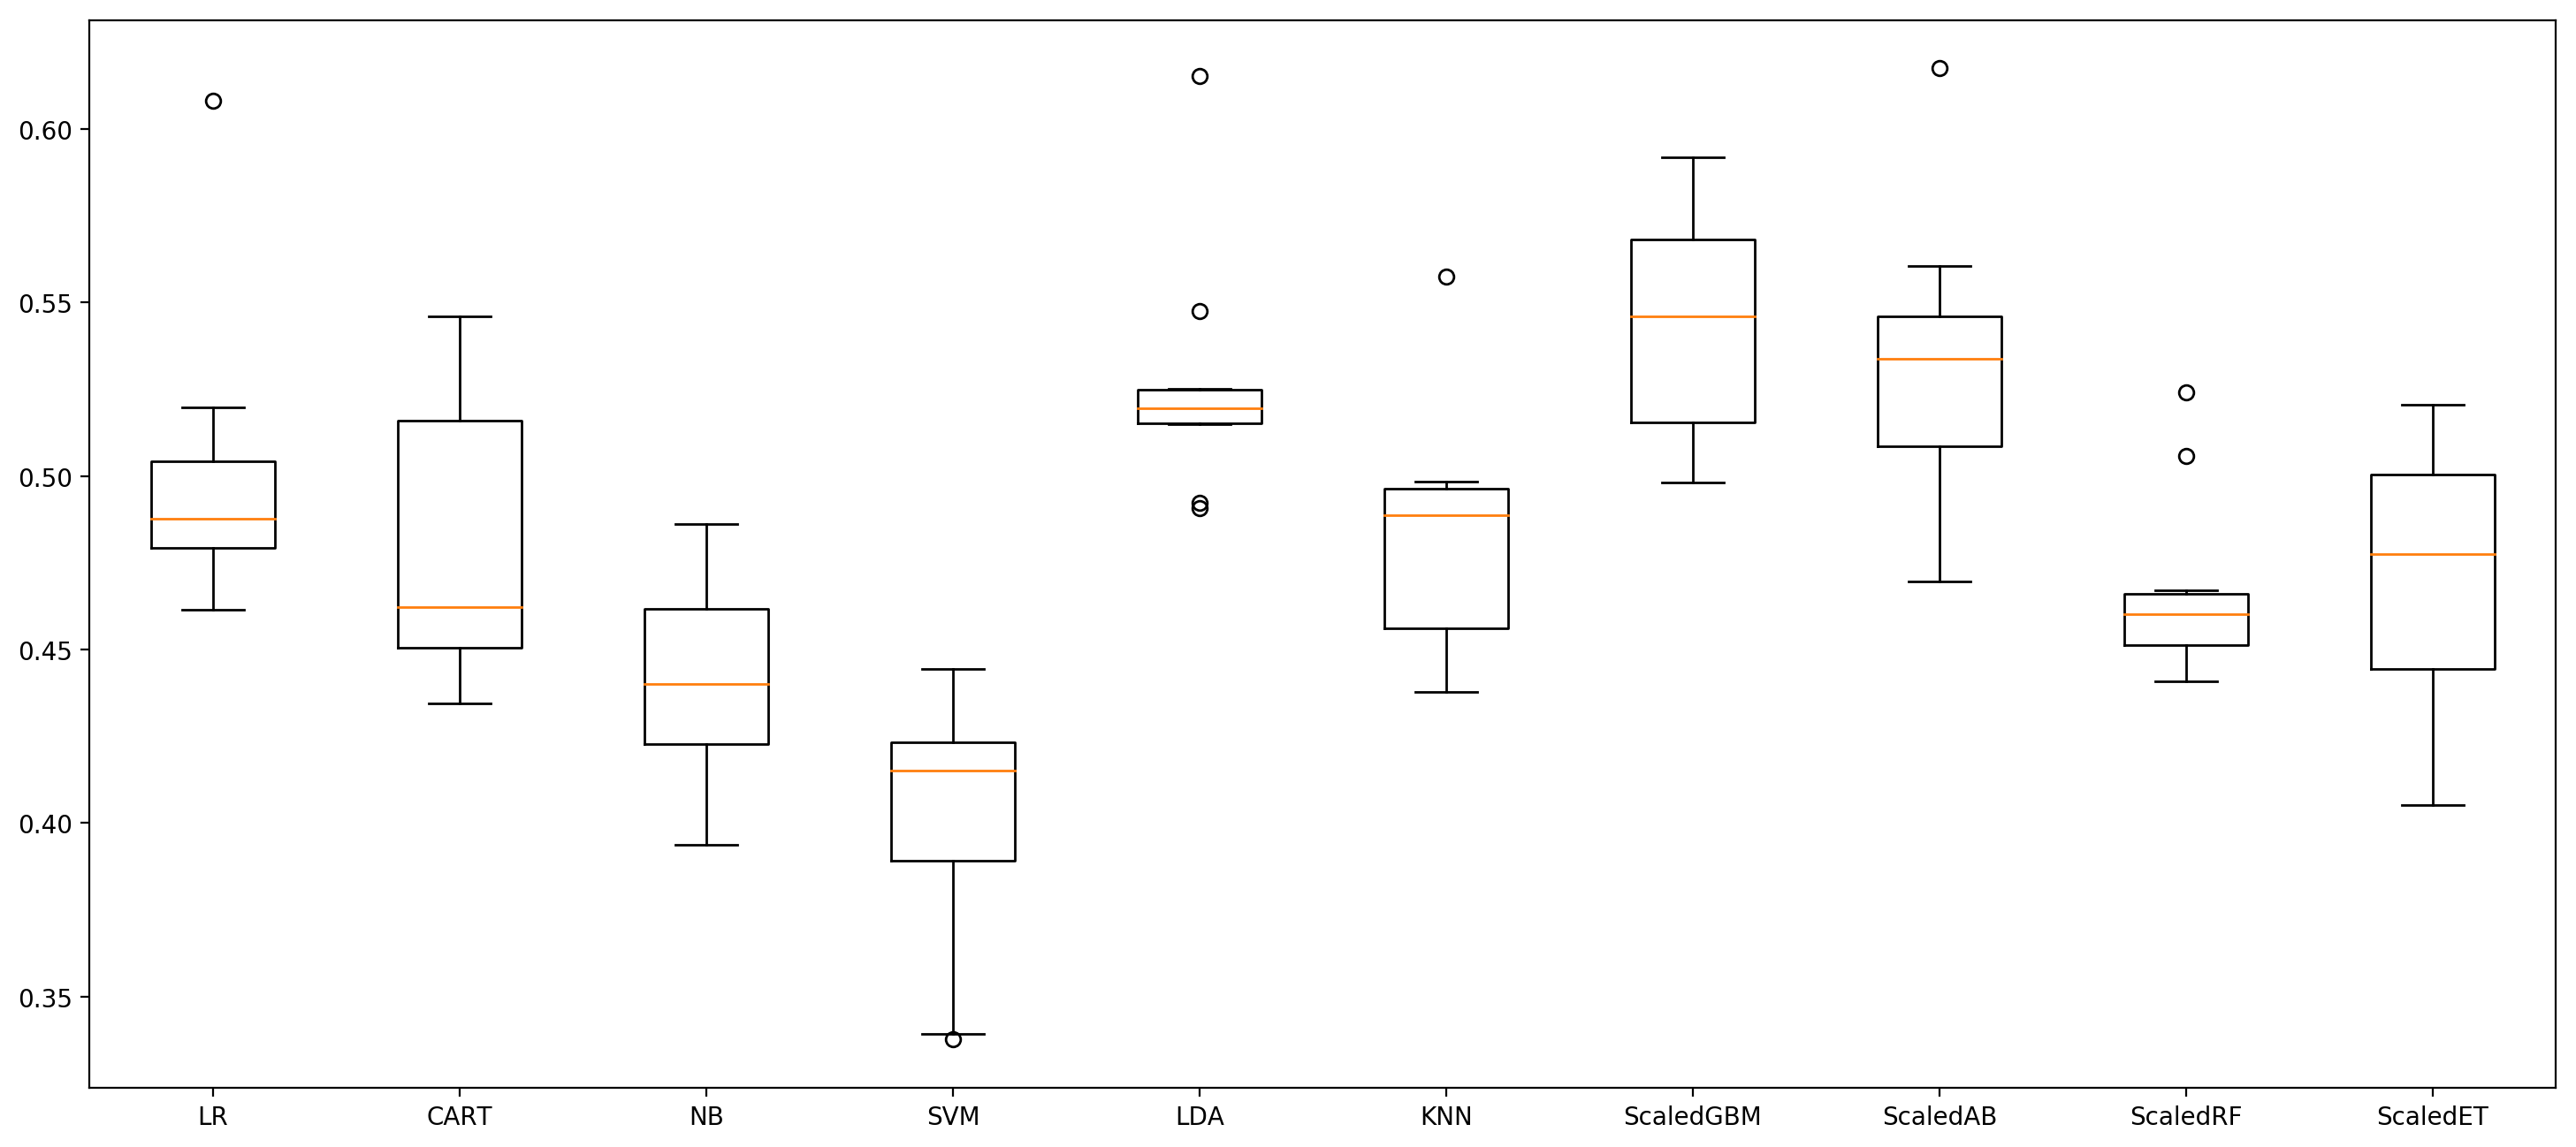

In [10]:
algorithm(X_t,y_t,'f1')

## 模型调参

In [28]:
from sklearn.model_selection import RandomizedSearchCV
model = GradientBoostingClassifier()
param = [{'learning_rate':[0.14,0.15],
         'max_depth':[2],
         'n_estimators':[160],
         'subsample':[0.9]},
        {'learning_rate':[0.15],
         'max_depth':[2],
         'n_estimators':[120],
         'subsample':[0.8]}]
param_learning_rate = {'learning_rate':[0.1,0.12,0.13,0.14,0.15],
                      'n_estimators':[80,100,120,130,140,160,200,250,300],
                      'max_depth':[1,2,3,4,5],
                     'subsample':[0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]}
gsv = GridSearchCV(model,param,cv=10,scoring='f1')
gsv.fit(X_t,y_t)
#rsc = RandomizedSearchCV(estimator=model,param_distributions=param,scoring='f1' )
#rsc.fit(X_t,y_t)
print("best params:{0}\nbest score:{1}".format(gsv.best_params_,gsv.best_score_))

best params:{'max_depth': 2, 'n_estimators': 160, 'learning_rate': 0.14, 'subsample': 0.9}
best score:0.5567950238684873


In [34]:
model = AdaBoostClassifier()
params = {
        'algorithm':['SAMME','SAMME.R'],
        'n_estimators':[70,90,120,140,200],
         'learning_rate':[0.7,0.8,0.9,1]}
rsc = RandomizedSearchCV(estimator=model,param_distributions=params,scoring='f1' )
rsc.fit(X_t,y_t)
print("best params:{0}\nbest score:{1}".format(rsc.best_params_,rsc.best_score_))

best params:{'learning_rate': 1, 'n_estimators': 120, 'algorithm': 'SAMME'}
best score:0.5480004950396746


## 模型保存和部署
1. 根据业务场景，生成预测源数据，保存在预测源数据表；
2. 导出预测源数据表，生成对应的csv文件，存放在源数据目录；
3. 调用预测算法脚本，加载对应模型和数据，将预测结果以csv文件方式保存在结果数据目录；
4. 将结果导入预测模型结果表
5. 每天跑前7天的实际用户留存数据，结合模型预测表的数据，生成验证表

## 数据表结构
#### 预测源数据表：
* 命名规范：pms_游戏代码_算法代码_场景代码，例如：pms_dfqp_lda_7days
* 字段：根据上面的模型字段来

#### 预测模型结果表：
* 命名规范：pmr_游戏代码_算法代码_场景代码，例如：pmr_dfqp_lda_7days
* 字段：日期、平台、用户ID、预测结果

#### 预测模型结果验证表：
* 命名规范：pmrv_游戏代码_算法代码_场景代码，例如：pmrv_dfqp_lda_7days
* 字段：用户ID，平台，预测结果，实际结果，预测日期，验证日期，是否正确

## 目录结构
* 根目录：veda
* 文件目录：veda/scripts/
    * 命名规范：游戏代码_算法代码_场景代码.py
* 模型目录：Veda/model/
    * 命名规范：游戏代码_算法代码_场景代码.model
* 数据目录：
    * 文件目录：
        * Veda/data/game/yyyymmdd/sData：存放源数据文件
        * Veda/data/game/yyyymmdd/rData：存放结果数据文件
    * 命名规范：
        * 源数据文件：pms_游戏代码_算法代码_场景代码_yyyymmdd.csv，例如pms_dfqp_lda_7days_20180709.csv，字段对应数据库表
        * 结果数据文件：pmr_游戏代码_算法代码_场景代码_yyyymmdd.csv，例如pmr_dfqp_lda_7days_20180709.csv，字段对应数据库表

#### 每天清理30天前的数据，根据日期目录删除


In [ ]:
GBC = GradientBoostingClassifier(max_depth=2,
                                learning_rate=0.14,
                                n_estimators=160,
                                subsample=0.9)
GBC_default = GradientBoostingClassifier()
GBC.fit(X_t,y_t)
from pickle import dump
save_model = '../models/dfqp/GBM.sav'
with open(save_model,'wb') as model_f:
    dump(model,model_f)

In [ ]:
from pickle import load
import datetime

# 获取昨天的日期
now = datetime.datetime.now()-datetime.timedelta(days = 1)
date = now.strftime('%Y%m%d')
# 拼接成文件名
predict_filename = 'training_data_yunnan_'+date+'.csv'

# 获取预测文件
predict_dir = '../data/dfqp/'
predict_path = predict_dir+predict_filename

# 读取文件
predict_file = pd.read_csv(predict_path)
# 获取预测字段
predict_values = predict_file.values
predict_X = predict_values[:,2:44]

# 获取模型
model_path = '../models/dfqp/GBM.sav'
# 利用模型进行预测
with open(model_path,'rb') as model_f:
    loaded_model = load(model_f)
    predict_y = loaded_model.predict(predict_X)

# 生成结果文件
fuid = predict_file['fuid']
fplatformname = predict_file['fplatformname']
dt = predict_file['dt']
result = pd.DataFrame({'dt':dt,'fplatformname':fplatformname,'fuid':fuid,'predict':predict_y})

# 保存结果文件
save_filename = 'predict_data_yunnan_'+date+'.csv'
predict_save_path = predict_dir+save_filename
result.to_csv(predict_save_path)